In [49]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from category_encoders import TargetEncoder
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# Define function to look up similar items 

In [2]:
def similar_items(track_uri, top_n, similarity_matrix):
    print('seed track is not included')
    D_rec={}
    time0 = time()
    idx = D_track_uri_to_id[track_uri]
    similarity_array = cosine_similarity(similarity_matrix[idx:idx+1,:], similarity_matrix)
    recc_tracks = np.fliplr(similarity_array.argsort())
    for el in recc_tracks[0][top_n]:
        D_rec[D_track_id_to_uri[el]]=similarity_array[0][el]
    print(f'{time()-time0:0.2f}sec')
    return D_rec

In [3]:
def similar_items_with_description(track_uri, top_n, similarity_matrix):
    print('CB audio features - first tracks returned is the seed track')
    D_rec={}
    time0 = time()
    idx = D_track_uri_to_id[track_uri]
    similarity_array = cosine_similarity(similarity_matrix[idx:idx+1,:], similarity_matrix)
    recc_tracks = np.fliplr(similarity_array.argsort())
    for el in recc_tracks[0][0:top_n+1]:
        D_rec[D_track_id_to_uri[el]]=D_desc[D_track_id_to_uri[el]]
    print(f'{time()-time0:0.2f}sec')
    return list(D_rec.values())

In [ ]:
def similar_items_with_description_external(track_uri, top_n):
    print('CB audio features - first tracks returned is the seed track')
    D_rec={}
    time0 = time()
    idx = D_track_uri_to_id[track_uri]
    similarity_array = cosine_similarity(X_transformed[idx:idx+1,:], X_transformed)
    recc_tracks = np.fliplr(similarity_array.argsort())
    for el in recc_tracks[0][0:top_n+1]:
        D_rec[D_track_id_to_uri[el]]=D_desc[D_track_id_to_uri[el]]
    print(f'{time()-time0:0.2f}sec')
    return list(D_rec.values())

# Load data

In [4]:
with open('../data-processed/full-data/track_descriptions.json') as json_file:
    D_desc = json.load(json_file)
    
D_desc['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI']

['Lose Control (feat. Ciara & Fat Man Scoop)', 'Missy Elliott', 'The Cookbook']

In [5]:
with open('../data-processed/full-data/track_artist_album.json') as json_file:
    D_album_artist = json.load(json_file)
    
D_album_artist['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI']

['spotify:artist:2wIVse2owClT7go1WT98tk',
 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K']

In [6]:
path = '../data-processed/full-data/audio-features-combined.csv'
data = pd.read_csv(path)

In [7]:
data = data.reset_index()
data = data.rename(columns = {'index':'track_id'})
data['artist_uri'] = data.apply(lambda x:D_album_artist[x.uri][0], axis = 1)
data['album_uri'] = data.apply(lambda x:D_album_artist[x.uri][1], axis = 1)

In [8]:
# data.head()

In [9]:
D_track_uri_to_id = data.groupby('uri')['track_id'].min().to_dict()
D_track_id_to_uri = data.groupby('track_id')['uri'].min().to_dict()

In [10]:
len(D_track_uri_to_id), len(D_track_id_to_uri)

(2262190, 2262190)

# Plot data

In [11]:
# data.iloc[:,1:-1].hist(figsize=(14,9))
# uncomment
# plt.show()

In [12]:
# fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(14,9))

# column = data.columns[2:14]

#uncomment
# for i in range(3):
#     for j in range(4):
#         sns.boxplot(data=data[column[i*4+j]], palette="Set1", ax=ax[i,j]).set_title(column[i*4+j])

# Standardize data 

In [13]:
X = data.iloc[:,2:13]

In [14]:
#column orders
data.iloc[:,2:13].columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [15]:
scaler = StandardScaler()
transformer = scaler.fit(X)
X_transformed = transformer.transform(X)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>, <AxesSubplot:>]],
      dtype=object)

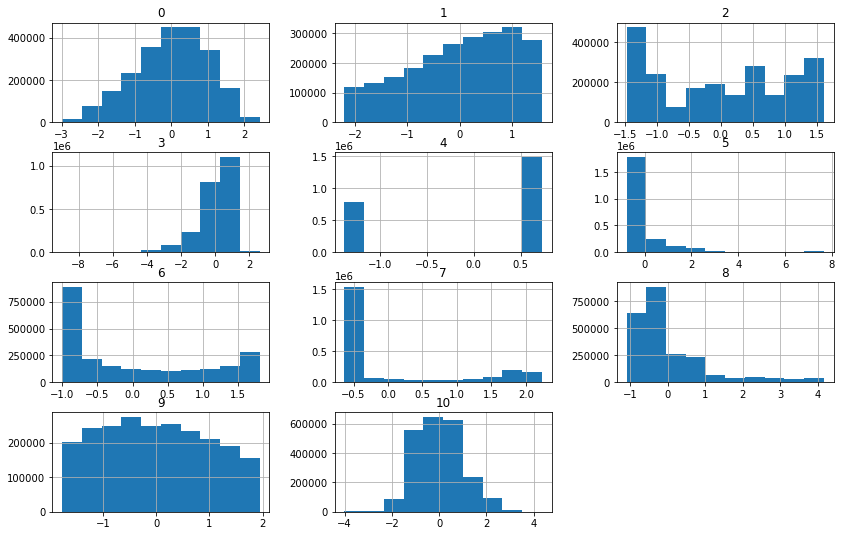

In [16]:
# uncomment
# pd.DataFrame(X_transformed).hist(figsize=(14,9))
# plt.show()

# Target encode album_uri and artist_uri

In [17]:
X_transformed.shape

(2262190, 11)

In [18]:
df_X_transformed = pd.DataFrame(X_transformed, columns=data.iloc[:,2:13].columns)
# df_X_transformed.head()

In [19]:
df_X_transformed.shape

(2262190, 11)

In [20]:
df_X_transformed.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

# Encode album_uri

In [21]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [22]:
df_X_transformed['album_uri'] = data.album_uri
X = data['album_uri'].values.reshape(-1,1)

In [23]:
enc = TargetEncoder()
for col in cols:
    y = df_X_transformed[col].values.reshape(-1,1)  
    df_X_transformed[f'album_uri_{col}_enc'] = enc.fit_transform(X, y)

In [24]:
# df_X_transformed.head()

# Encode artist_uri

In [25]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [26]:
df_X_transformed['artist_uri'] = data.artist_uri
X = data['artist_uri'].values.reshape(-1,1)

In [27]:
enc = TargetEncoder()
for col in cols:
    y = df_X_transformed[col].values.reshape(-1,1) 
    df_X_transformed[f'artist_uri_{col}_enc'] = enc.fit_transform(X, y)

In [28]:
# df_X_transformed.head()

In [29]:
X_transformed = df_X_transformed.drop(columns=['artist_uri','album_uri']).to_numpy()

# Perform PCA

In [30]:
X_transformed.shape

(2262190, 33)

In [31]:
pca = PCA(n_components='mle')
pca = pca.fit(X_transformed)

In [32]:
# print(pca.explained_variance_ratio_)

In [33]:
X_transformed_pca = pca.transform(X_transformed)

> Let us run PCA with 15 factors

In [34]:
pca = PCA(n_components=15)
pca = pca.fit(X_transformed)
print(pca.explained_variance_ratio_)

[0.31535805 0.11036058 0.09556642 0.0776244  0.056072   0.05212492
 0.04761578 0.04211778 0.02992701 0.02492938 0.02194851 0.01280679
 0.01257967 0.01206744 0.01069738]


In [35]:
print(f'Explained variance = {np.sum(pca.explained_variance_ratio_):0.2f}')

Explained variance = 0.92


In [36]:
X_transformed_pca = pca.transform(X_transformed)

# Find similar tracks

<img src="tenor.gif">

In [59]:
similar_items_with_description('spotify:track:3ZOEytgrvLwQaqXreDs2Jx',10,X_transformed)

CB audio features - first tracks returned is the seed track
1.08sec


[["Can't Stop", 'Red Hot Chili Peppers', 'By The Way'],
 ['Did I Let You Know', 'Red Hot Chili Peppers', "I'm With You"],
 ['Forget Me Now', 'Against The Current', 'In Our Bones'],
 ['Warlocks', 'Red Hot Chili Peppers', 'Stadium Arcadium'],
 ['Miracle', 'Ghost Beach', 'Blonde'],
 ['Halo', 'The Pass', 'Melt'],
 ['Children Of The Gun', 'Drowning Pool', 'Drowning Pool'],
 ['Vegas', 'Semi Precious Weapons', 'Aviation'],
 ["You Can't Put Your Arms Around What's Already Gone",
  'Roxette',
  'Have A Nice Day'],
 ['Lackluster', 'Caskitt', 'This Machine Kills Sadness'],
 ['Here With You', 'Sing It Loud', 'Everything Collide']]

In [38]:
# similar_items_with_description('spotify:track:3DK6m7It6Pw857FcQftMds',10,X_transformed)

In [39]:
# similar_items_with_description('spotify:track:3XplJgPz8VjbDzbGwGgZdq',15,X_transformed)

In [40]:
# similar_items_with_description('spotify:track:3jagJCUbdqhDSPuxP8cAqF',15,X_transformed)

In [41]:
# similar_items_with_description('spotify:track:79XrkTOfV1AqySNjVlygpW',15,X_transformed)

In [42]:
# similar_items_with_description('spotify:track:4X5f3vT8MRuXF68pfjNte5',15,X_transformed)

In [43]:
# similar_items_with_description('spotify:track:5fwP61Nmo5xXYIjO9XEWqb',15,X_transformed)

# Playlist recommendations

In [44]:
evaluation_set = pd.read_csv('../data-processed/full-data/evaluation-pids-ground-truth.csv')
evaluation_set.head()

,pid,pos,track_uri,hold_out,seed_pattern
0,491004,0,spotify:track:5dNfHmqgr128gMY2tc5CeJ,0,first n
1,491004,1,spotify:track:557un1HgwYMuqfWGSTmnxw,0,first n
2,491004,2,spotify:track:6Ms01Gqi8gVBs14YrNUlVZ,0,first n
3,491004,3,spotify:track:7J41dYQolQJEtj3UmKLu5r,0,first n
4,491004,4,spotify:track:6LGwYMXXgURfaequXipzHx,0,first n


In [46]:
ev_set = evaluation_set[evaluation_set['hold_out'] == 1][['pid','track_uri','hold_out']]
ev_set = ev_set[ev_set.isnull()==False]

ev_set_arr = ev_set.to_numpy()

evaluation_pids = list(ev_set.pid.unique())

ev_set.head()

,pid,track_uri,hold_out
38,491004,spotify:track:7i7UIbm5E0DD7aSOYvwp2v,1
39,491004,spotify:track:0FZvjrHpAmLKj574M4VwrF,1
40,491004,spotify:track:0rE8OLQpoOFe2xa35twgve,1
41,491004,spotify:track:4rY3KONqdimczgu2NhxI8k,1
42,491004,spotify:track:6DkXLzBQT7cwXmTyzAB1DJ,1


In [ ]:
D_evaluation ={}

for pid in list(ev_set.pid.unique()):
    D_evaluation[pid] = list(ev_set[ev_set.pid==pid].track_uri.unique())

In [ ]:
D_train ={}

for pid in list(data.pid.unique()):
    D_train[pid] = list(data[data.pid==pid].track_uri.unique())

In [ ]:
D_evaluation

In [ ]:
D_train

In [ ]:
import json

with open('../data-processed/full-data/D_evaluation.json', 'w') as fp:
    json.dump(D_evaluation, fp)

with open('../data-processed/full-data/D_train.json', 'w') as fp:
    json.dump(D_train, fp)

In [52]:
for el in random.sample(evaluation_pids,10)[:1]:
    for key, val in D_train[pid]:
        similar_items(val,10,X_transformed)

seed track is not included


KeyError: 555638

In [ ]:
def als_predict_and_evaluate_top_n(pid, top_n=100):
    """
    return
    (1) top_n predicted: track_ids
    (2) ground_truth : track_ids in the hold_out
    (3) R_Prec
    (4) NDGC
    
    """
    L_pred = list(create_recs_dictionary_output(pid,top_n).keys())
    
    ground_truth = ev_set_arr[ev_set_arr[:,0]==pid][:,1]
    
    R_Prec = R_Precision(L_pred[:len(ground_truth)],ground_truth)
    
    res = [int(el in ground_truth) for el in L_pred]
    
    NDCG = nDCG(res)[1]
    
    return L_pred, ground_truth, R_Prec, NDCG, res